In [ ]:
#%pip install -U langchain-tavily
# https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#5-create-a-function-to-run-the-tools

# add-tool

In [17]:
import dotenv
dotenv.load_dotenv()
import os
if os.environ["TAVILY_API_KEY"]:
    print("TAVILY_API_KEY OK!")
if os.environ["DEEPSEEK_API_KEY"]:
    print("DEEPSEEK_API_KEY OK!")

TAVILY_API_KEY OK!
DEEPSEEK_API_KEY OK!


In [8]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-maki

In [18]:
import os

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")



In [19]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [21]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

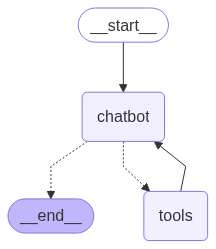

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 我需要知道您所在的具体位置才能查询今天的天气情况。请告诉我您想查询哪个城市的天气？
Assistant: 我来帮您查询贵阳市的天气情况。
Assistant: {"query": "\u8d35\u9633\u5e02\u5929\u6c14\u9884\u62a5", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://m.weather.com.cn/mweather15d/101260101.shtml", "title": "\u8d35\u9633\u5929\u6c14\u9884\u62a515\u5929\u67e5\u8be2", "content": "8~15\u00e5\u00a4\u00a9\u00e5\u00a4\u00a9\u00e6\u00b0\u0094\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00ef\u00bc\u008c\u00e6\u0098\u00af\u00e9\u009b\u0086\u00e5\u0090\u0088\u00e5\u00a4\u009a\u00e5\u00ae\u00b6\u00e5\u0085\u00a8\u00e7\u0090\u0083\u00e6\u0095\u00b0\u00e5\u0080\u00bc\u00e5\u00a4\u00a9\u00e6\u00b0\u0094\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00e6\u00a8\u00a1\u00e5\u00bc\u008f\u00e5\u00ae\u00a2\u00e8\u00a7\u0082\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00e4\u00ba\u00a7\u00e5\u0093\u0081\u00e5\u008a \u00e5\u00b7\u00a5\u00e8\u0080\u008c\u00e6\u0088\u0090\u00ef\u00bc\u008c\u00e6\u009c\u00aa\u00e7\u00bb\u008f\u00e9\u00a2\u0084\u00e6\u

In [1]:
import os

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

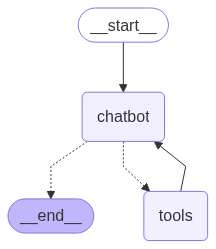

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# add memory

In [3]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [4]:
graph = graph_builder.compile(checkpointer=memory)

In [5]:
config = {"configurable": {"thread_id": "1"}}

In [6]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. I'm here to help you with any questions or information you might need. What can I assist you with today?


In [7]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember! Your name is Will. It's nice to talk with you again. What would you like to discuss or explore today?


In [8]:
user_input = "Remember my name?"
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information like your name between conversations. Each time we interact, I start fresh without access to previous conversations or personal details you may have shared.

If you'd like me to refer to you by a specific name during our current conversation, please feel free to tell me what you'd like to be called!


In [9]:
user_input = "Remember my name?"
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will! You introduced yourself at the beginning of our conversation. Is there something specific you'd like help with today?


In [10]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='7ec90a9e-75f2-45e3-9e4f-564d964e63f8'), AIMessage(content="Hi Will! Nice to meet you. I'm here to help you with any questions or information you might need. What can I assist you with today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1806, 'total_tokens': 1837, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1792}, 'prompt_cache_hit_tokens': 1792, 'prompt_cache_miss_tokens': 14}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_feb633d1f5_prod0820_fp8_kvcache', 'id': '088b9272-9fcc-498f-82ed-f895a67a250d', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--f0b940e1-b2ca-4e57-a892-48f63edafed1-0', usage_metadata={'input_tokens': 1806, 'output_tokens': 31, 'total_tokens': 1837, 'input_token_details': {

# human in the loop

In [26]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [27]:
# human in the loop
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [28]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

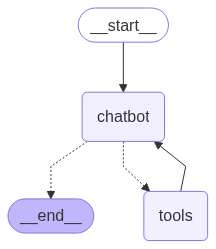

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

I'd be happy to help you get expert guidance for building an AI agent! To request the most relevant assistance for you, could you please provide a bit more detail about what specific aspects of AI agent building you need help with? For example:

- Are you looking for guidance on the overall architecture?
- Do you need help with specific frameworks or tools?
- Are you working on a particular type of agent (conversational, task-oriented, etc.)?
- Do you have questions about training, deployment, or scaling?

The more specific you can be about your needs, the better I can request targeted assistance for you.


In [33]:
user_input = "okey, great. I need some expert guidance for building an AI agent. Could you request assistance for me? you may use human_assistance to help me test Human command in langchain..."
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

okey, great. I need some expert guidance for building an AI agent. Could you request assistance for me? you may use human_assistance to help me test Human command in langchain...
================================== Ai Message ==================================

I'll request human assistance for you to get expert guidance on building an AI agent and testing human commands in LangChain.
Tool Calls:
  human_assistance (call_0_db73f97e-9453-452a-8b68-577d77e9a84d)
 Call ID: call_0_db73f97e-9453-452a-8b68-577d77e9a84d
  Args:
    query: I need expert guidance for building an AI agent, specifically focusing on implementing and testing human command functionality in LangChain. The user is looking for assistance with AI agent development and wants to understand how to properly integrate human interaction capabilities.


In [34]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [35]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'll request human assistance for you to get expert guidance on building an AI agent and testing human commands in LangChain.
Tool Calls:
  human_assistance (call_0_db73f97e-9453-452a-8b68-577d77e9a84d)
 Call ID: call_0_db73f97e-9453-452a-8b68-577d77e9a84d
  Args:
    query: I need expert guidance for building an AI agent, specifically focusing on implementing and testing human command functionality in LangChain. The user is looking for assistance with AI agent development and wants to understand how to properly integrate human interaction capabilities.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Perfect